In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [4]:
# from hscode6_names.py import *

In [5]:
def get_panjiva():
    df = pd.read_csv('portof(un)lading/panjivausimport_imputevalue_shippingtime_yq.csv')
    df = df[['gvkey', 'year', 'quarter', 'hscode6', 'shpcountry', 'valueofgoodsusd_new', 'volumeteu', 'weightkg']]

    df = df[df.year>2007]
    return df

In [6]:
# sector: auto
def get_data(sector_list):

    df = get_panjiva()
    
    df['hscode6_str'] = df['hscode6'].astype(str)
    df['hscode4_str'] = df['hscode6_str'].str.slice(stop=3)
    df['hscode4'] = df['hscode4_str'].astype(int)
    
    df = df[df['hscode6'].isin(sector_list)]
    
    df['qs'] = df['year'].astype(str) +'-Q'+ df['quarter'].astype(str)
    df['date'] = pd.PeriodIndex(df['qs'], freq='Q').to_timestamp()
    
    return df

In [7]:
def get_data_aggr(df, sector_list, country_list, aggr_country=[], aggr_country_name='SAC'):

    # gen column 'source'
    if(len(aggr_country)>0): 
        df['source'] = np.where(df['shpcountry'].isin(aggr_country), aggr_country_name, 'Other') 
    if(len(aggr_country)==0): 
        df['source'] = 'Other'
        aggr_country = []

    for country in list(set(country_list).difference(set(aggr_country))):
        df.loc[df['shpcountry']==country, 'source'] = country 
        
    return df

In [10]:
def get_ordered_source(df, output):
    
    serie = df[['source', output]].groupby(['source']).sum().unstack()
    serie = pd.to_numeric(serie, downcast="integer").sort_values(ascending=False)
    df = pd.DataFrame(serie.reset_index(inplace=False))

    df = df.drop(columns=['level_0'])
    df.columns = ['source', output]

    return df['source']
   

In [41]:
# output: 'valueofgoodsusd_new'
def get_plot_ts(df, output, title, period, aggr_country_name, hp='NO', hp_lambda=100):
    
    ordered_source = get_ordered_source(df, output)
    
    df = df[['date', 'year', 'quarter', 'source', output]].groupby(['date', 'year', 'quarter', 'source']).sum().unstack()
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    
    # generate date as Quartil
    df['fecha'] = pd.to_datetime(df['date'], format ='%Y-%m-%d') 
    df = df.drop('date', axis=1)
    df['month'] = pd.DatetimeIndex(df['fecha']).month
    df.loc[df['month']==1, 'month'] = 3
    df.loc[df['month']==4, 'month'] = 6
    df.loc[df['month']==7, 'month'] = 9
    df.loc[df['month']==10, 'month'] = 12
    df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
    df = df.drop(['fecha', 'year', 'month', 'quarter'], axis=1)
    
    df = df[df.date>=period[0]]
    df = df[df.date<=period[1]]


    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(50*cm, 20*cm))
    
    for country in ordered_source:        
        if hp=='NO':
            serie = np.array(df[country]).astype(np.double)
            mask = np.isfinite(serie)
            
            plt.plot(df["date"][mask], serie[mask], label=country)
        if hp=='YES':
            cycle, trend = sm.tsa.filters.hpfilter(df[country], hp_lambda)
            df[country+'_hp'] = trend
            
            serie = np.array(df[country+'_hp']).astype(np.double)
            mask = np.isfinite(serie)
            
            plt.plot(df["date"][mask], serie[mask], label=country)
        
    plt.title(title)
    plt.ylabel(output)
    plt.xlabel("Period of time")
    
    plt.xticks(df["date"], rotation='vertical')
    
    if pd.to_datetime("2018-07-01", format = '%Y-%m-%d')>=pd.to_datetime(period[0], format = '%Y-%m-%d'):
        plt.axvline(pd.to_datetime("2018-07-01", format = '%Y-%m-%d'), color="red", linestyle="dashed",
                   label='06/07/2018: US-China trade war begins')
        
    plt.axvline(pd.to_datetime("2020-08-17", format = '%Y-%m-%d'), color="blue", linestyle="dashed",
               label='17/08/2020: COVID-19 becomes the 3rd leading cause of death in the U.S.')

    plt.legend()
    plt.show()
    

In [42]:
def get_plot(sector_list, country_list, aggr_country, aggr_country_name,
             output='volumeteu', title='Automobile imports', period=["2008-03-01", "2022-03-01"], hp='NO', hp_lambda=100):
    
    df = get_data(sector_list)
    df = get_data_aggr(df, sector_list, country_list, aggr_country, aggr_country_name)
    get_plot_ts(df, output, title, period, aggr_country_name, hp=hp, hp_lambda=hp_lambda)

In [17]:
def get_sector_list(start_sector_code):

    df = get_panjiva()

    # get array of unique integer of hscode6
    hscode6_list = [x for x in map(str, df['hscode6'].unique()) if x.startswith(start_sector_code)]

    # transform to integer
    hscode6_array = [int(i) for i in hscode6_list]
    
    return hscode6_array

In [18]:
def get_max_countries(N, sector_list, output):

    df = get_data(sector_list)

    serie = df[['shpcountry', output]].groupby(['shpcountry']).sum().unstack()
    serie = pd.to_numeric(serie, downcast="integer").sort_values(ascending=False)
    df2 = pd.DataFrame(serie.reset_index(inplace=False))

    df2 = df2.drop(columns=['level_0'])
    df2.columns = ['source', output]
    
    return list(df2[:5]['source'])

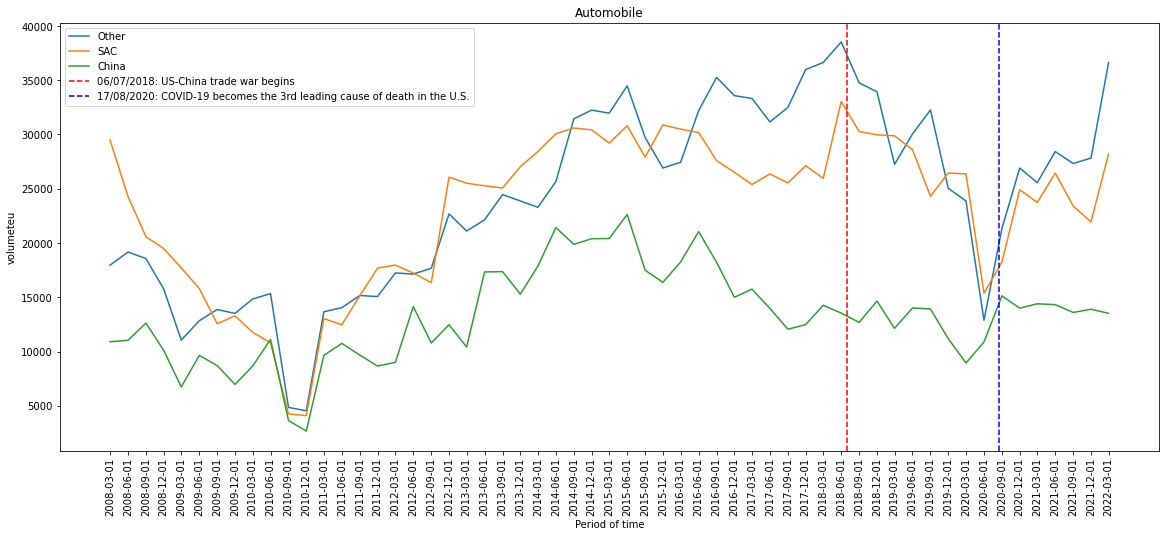

In [19]:
start_sector_code = '87'
sector_list = get_sector_list(start_sector_code)

country_list = ['China', 'India', 'Vietnam', 'Philippines', 'Malaysia', 'Thailand', 
                'Japan', 'Taiwan', 'Indonesia', 'Cambodia', 'Singapore', 'Bangladesh']

aggr_country = ['India', 'Vietnam', 'Philippines', 'Malaysia', 'Thailand', 
                'Japan', 'Taiwan', 'Indonesia', 'Cambodia', 'Singapore', 'Bangladesh']

aggr_country_name = "SAC"

get_plot(sector_list, country_list, aggr_country, aggr_country_name,
         output='volumeteu', 
         title='Automotive', 
         period=["2008-03-01", "2022-03-01"])

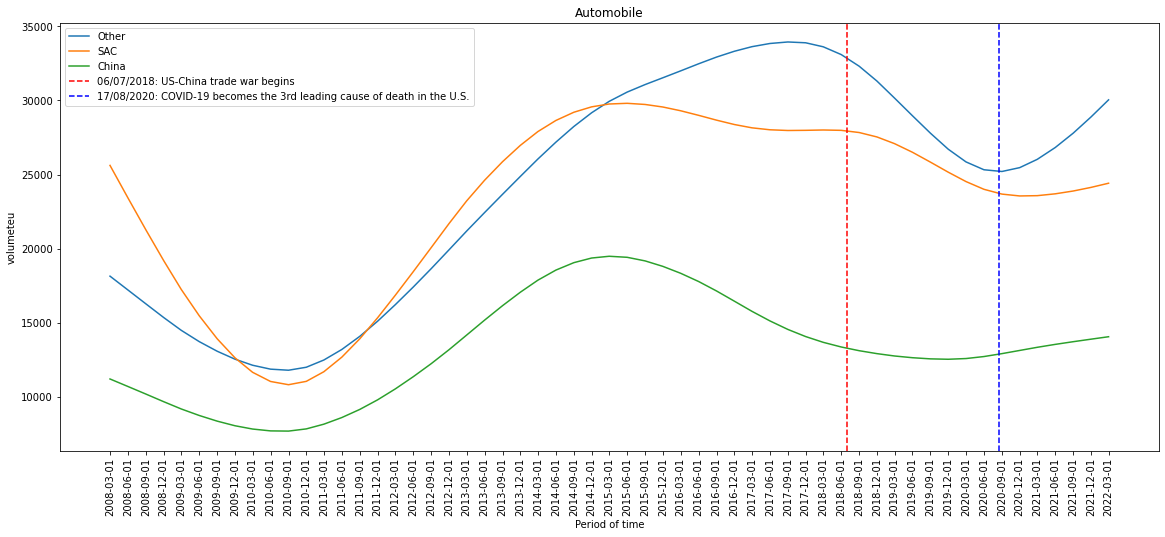

In [29]:
start_sector_code = '87'
sector_list = get_sector_list(start_sector_code)

country_list = ['China', 'India', 'Vietnam', 'Philippines', 'Malaysia', 'Thailand', 
                'Japan', 'Taiwan', 'Indonesia', 'Cambodia', 'Singapore', 'Bangladesh']

aggr_country = ['India', 'Vietnam', 'Philippines', 'Malaysia', 'Thailand', 
                'Japan', 'Taiwan', 'Indonesia', 'Cambodia', 'Singapore', 'Bangladesh']

aggr_country_name = "SAC"

get_plot(sector_list, country_list, aggr_country, aggr_country_name,
         output='volumeteu', 
         title='Automotive', 
         period=["2008-03-01", "2022-03-01"],
         hp='YES', hp_lambda=100)

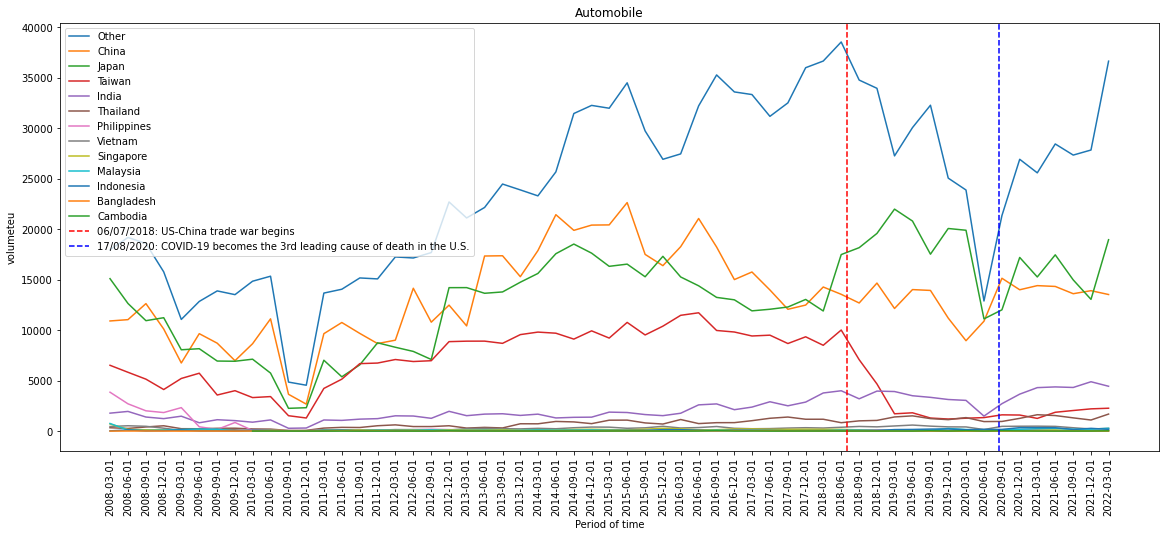

In [21]:
start_sector_code = '87'
sector_list = get_sector_list(start_sector_code)

country_list = ['China', 'India', 'Vietnam', 'Philippines', 'Malaysia', 'Thailand', 
                'Japan', 'Taiwan', 'Indonesia', 'Cambodia', 'Singapore', 'Bangladesh']

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title='Automotive', 
         period=["2008-03-01", "2022-03-01"])

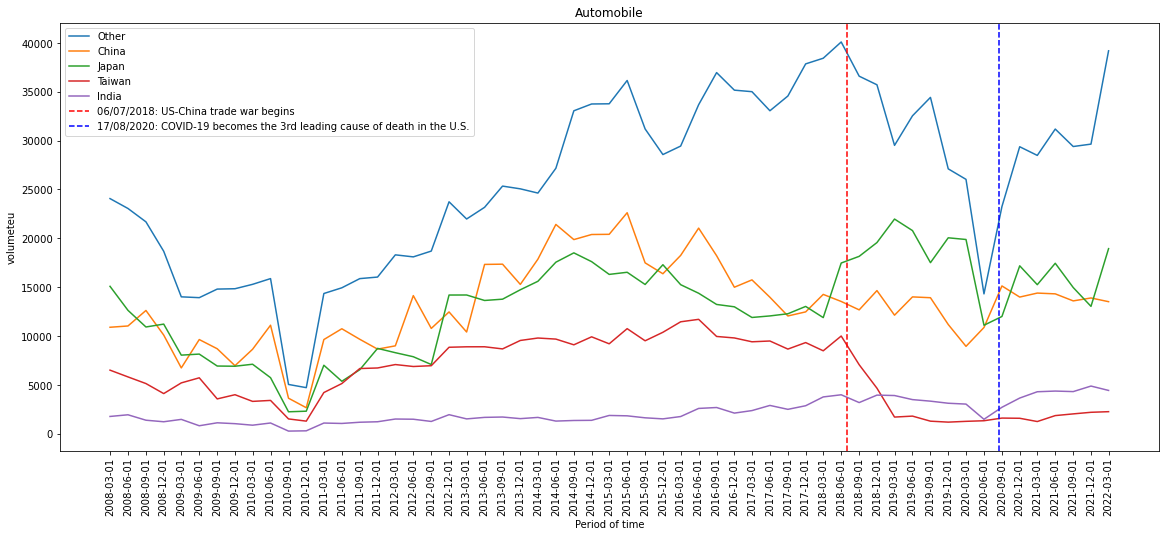

In [22]:
start_sector_code = '87'
sector_list = get_sector_list(start_sector_code)

country_list = ['China', 'Japan', 'Taiwan', 'India']

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title='Automotive', 
         period=["2008-03-01", "2022-03-01"])

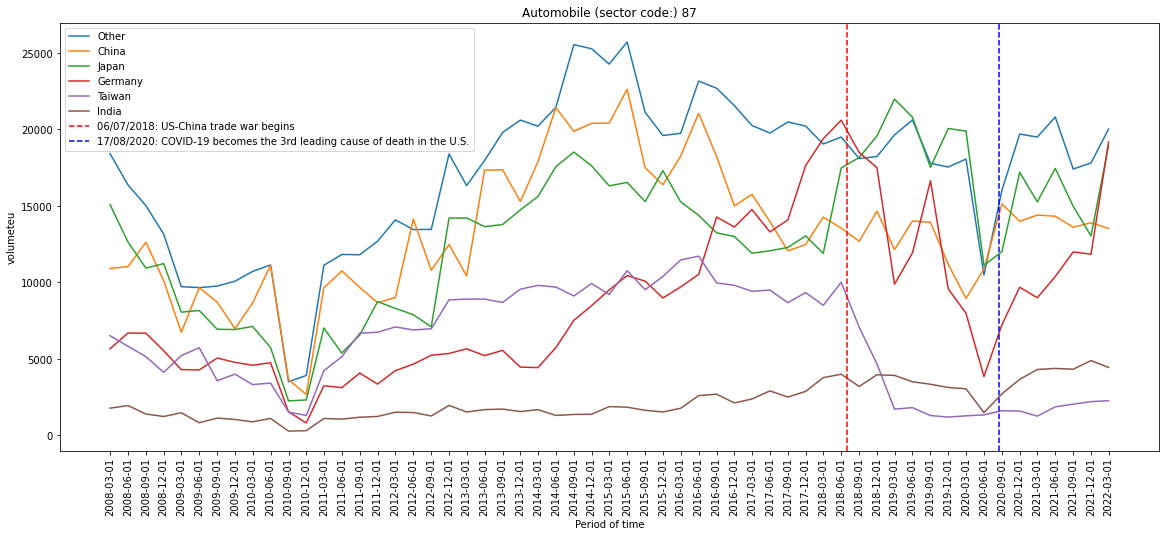

In [25]:
start_sector_code = '87'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title='Automotive '+'(sector code: '+start_sector_code+')', 
         period=["2008-03-01", "2022-03-01"])

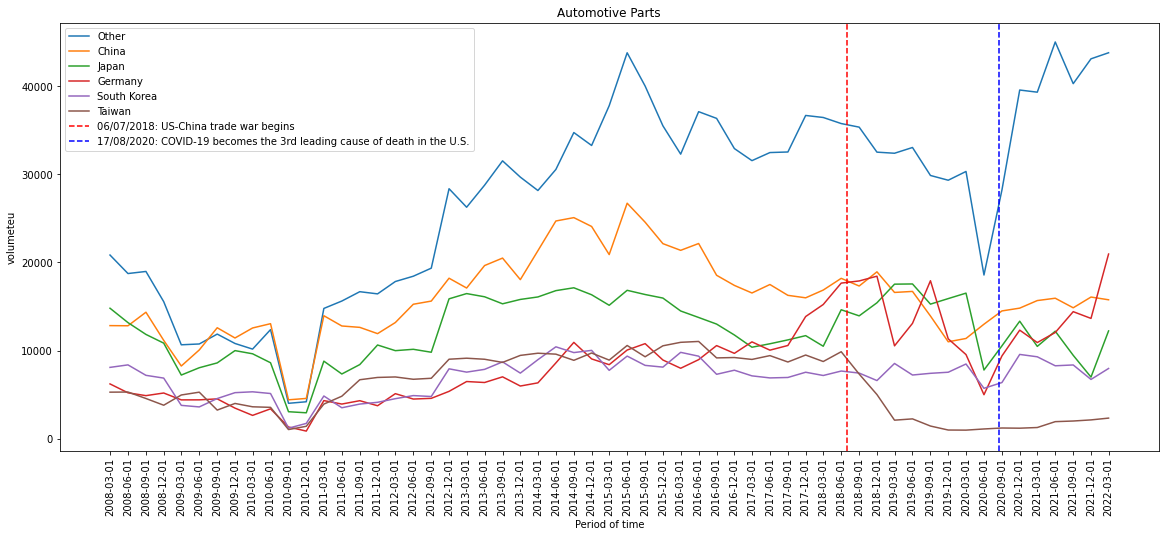

In [37]:
sector_list = pd.read_csv('automotive_parts_product_codes.csv')['code']
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title='Automotive Parts', 
         period=["2008-03-01", "2022-03-01"],
         hp='NO')

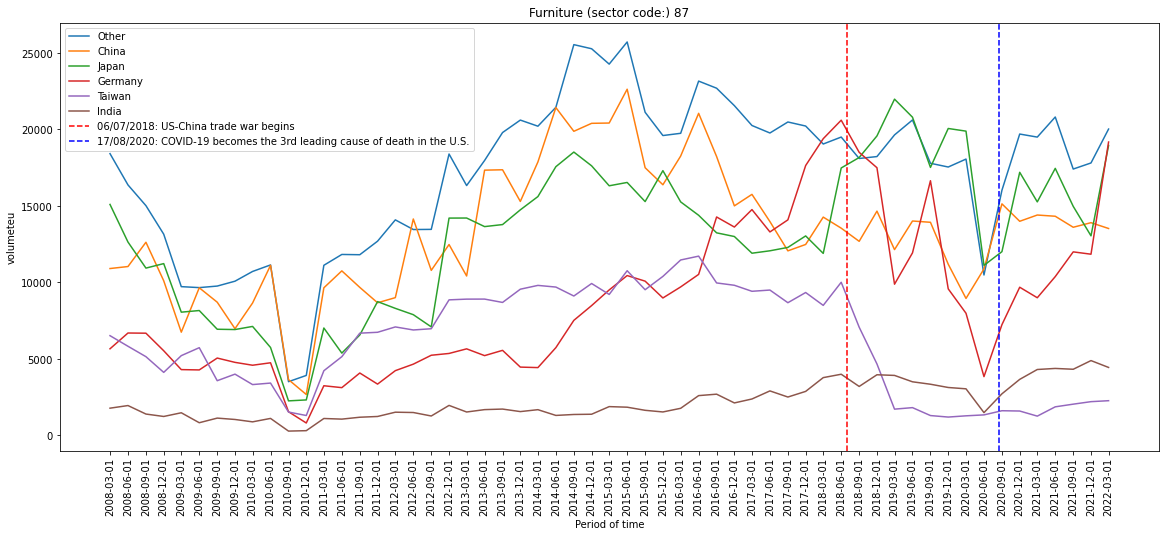

In [44]:
# 94 - Furniture
sector_name = 'Furniture'
start_sector_code = '94'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

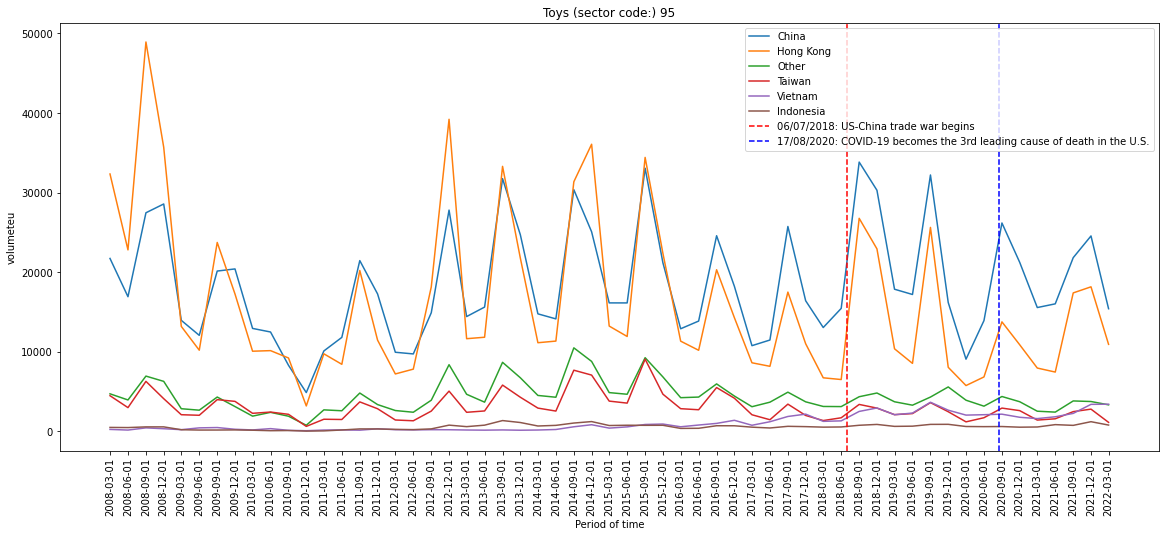

In [45]:
# 95 - Toys
sector_name = 'Toys'
start_sector_code = '95'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

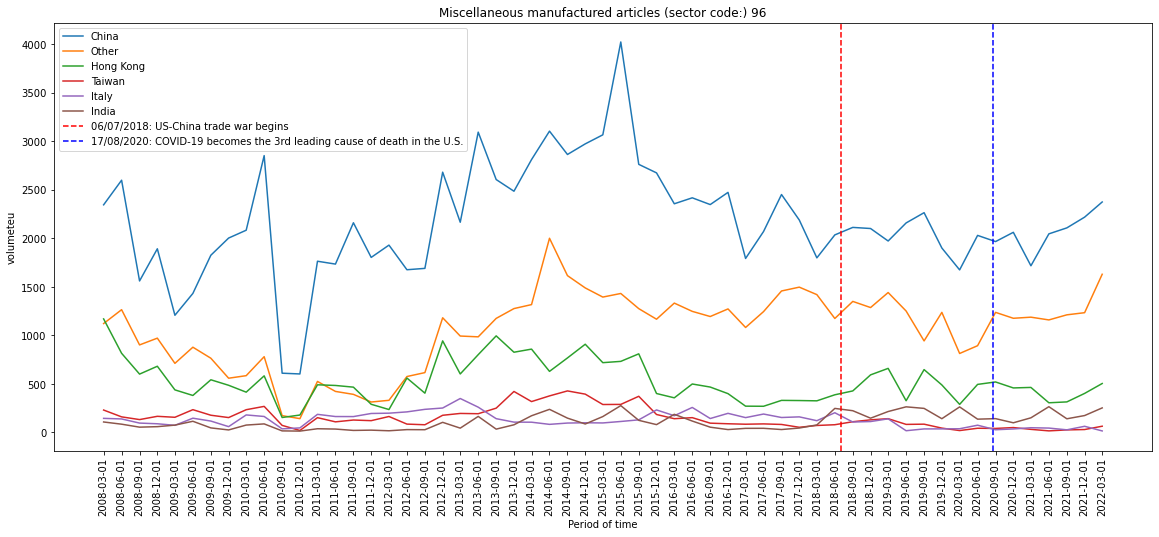

In [46]:
# 96 - Miscellaneous manufactured articles
sector_name = 'Miscellaneous manufactured articles'
start_sector_code = '96'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

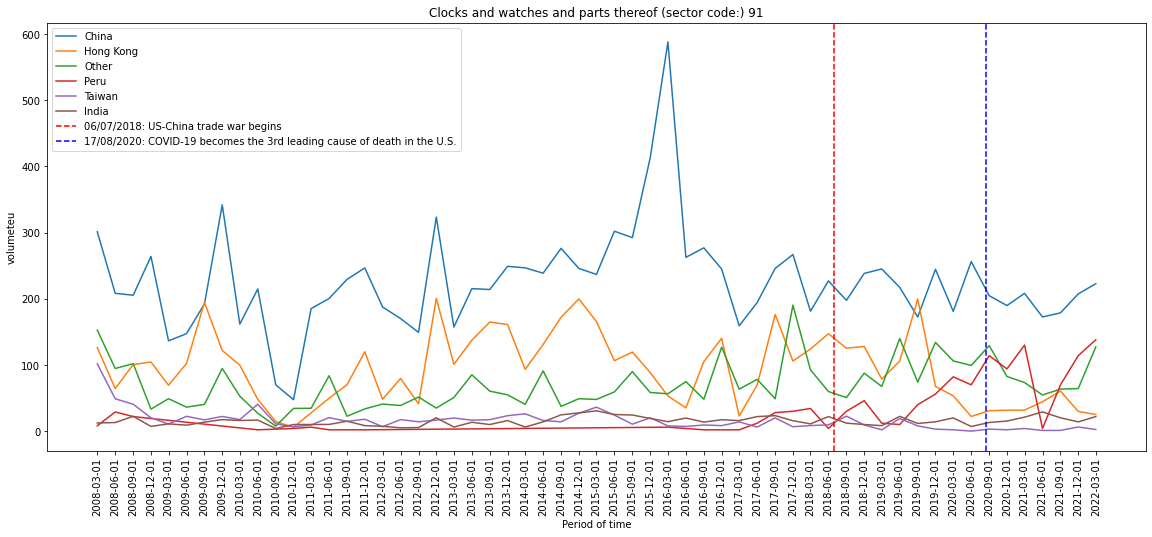

In [47]:
# 91 - Clocks and watches and parts thereof
sector_name = 'Clocks and watches and parts thereof'
start_sector_code = '91'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')', 
         period=["2008-03-01", "2022-03-01"])

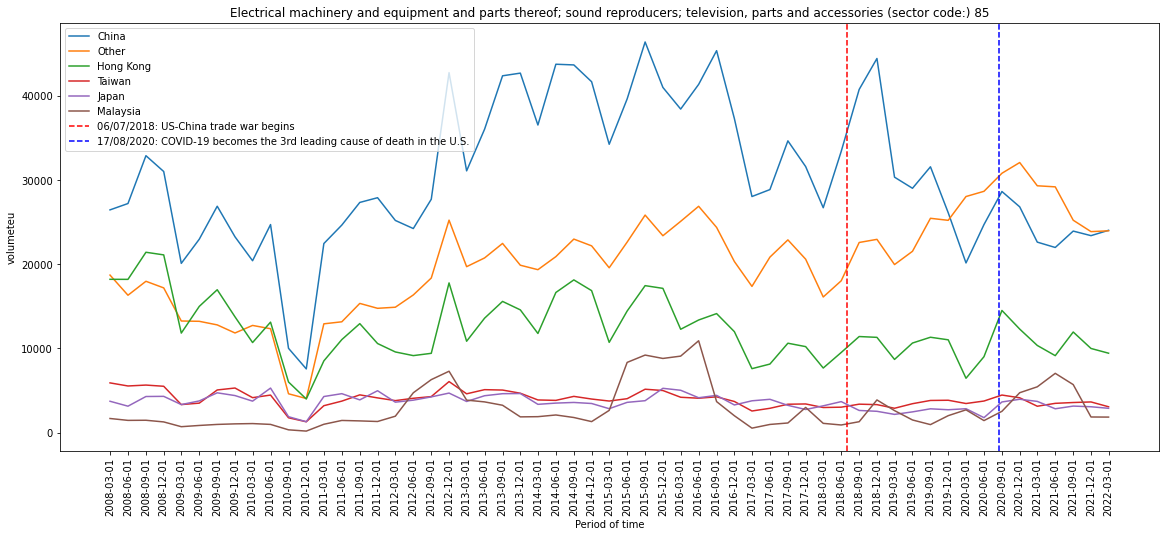

In [48]:
# 85 - Electrical machinery and equipment and parts thereof; sound reproducers; television, parts and accessories.
sector_name = 'Electrical machinery and equipment and parts thereof; sound reproducers; television, parts and accessories.'
start_sector_code = '85'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

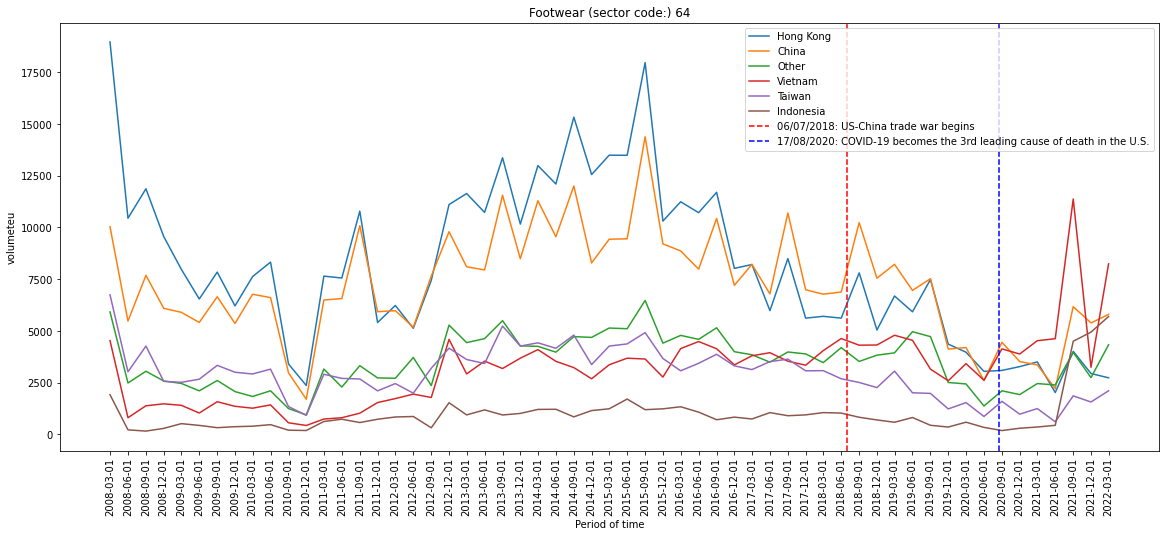

In [49]:
# 64 - Footwear; gaiters and the like; parts of such articles
sector_name = 'Footwear; gaiters and the like; parts of such articles'
start_sector_code = '64'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

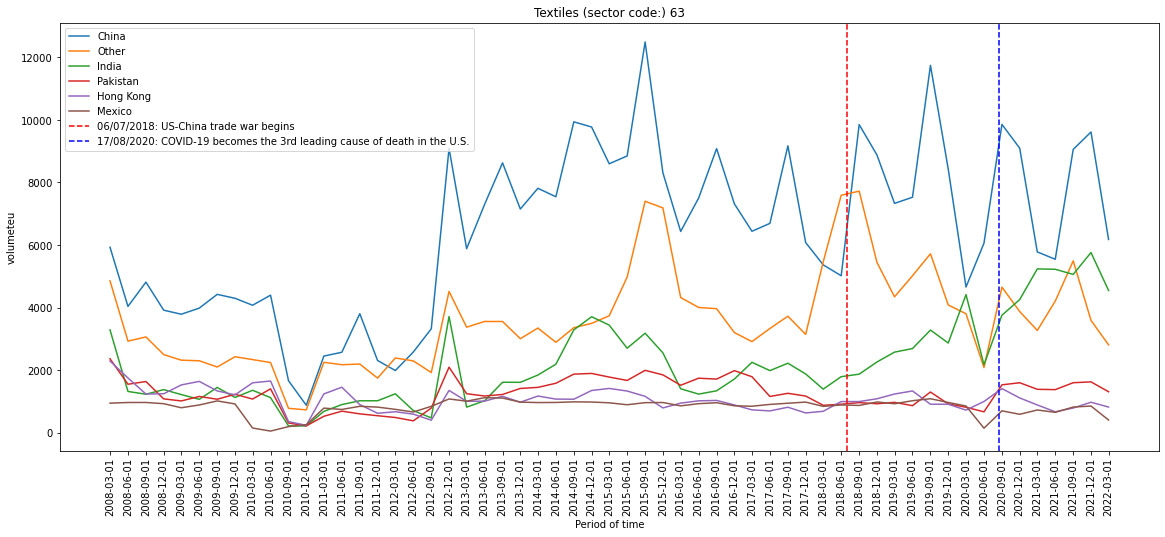

In [50]:
# 63 - Textiles, made up articles; sets; worn clothing and worn textile articles; rags
sector_name = 'Textiles, made up articles; sets; worn clothing and worn textile articles; rags'
start_sector_code = '63'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

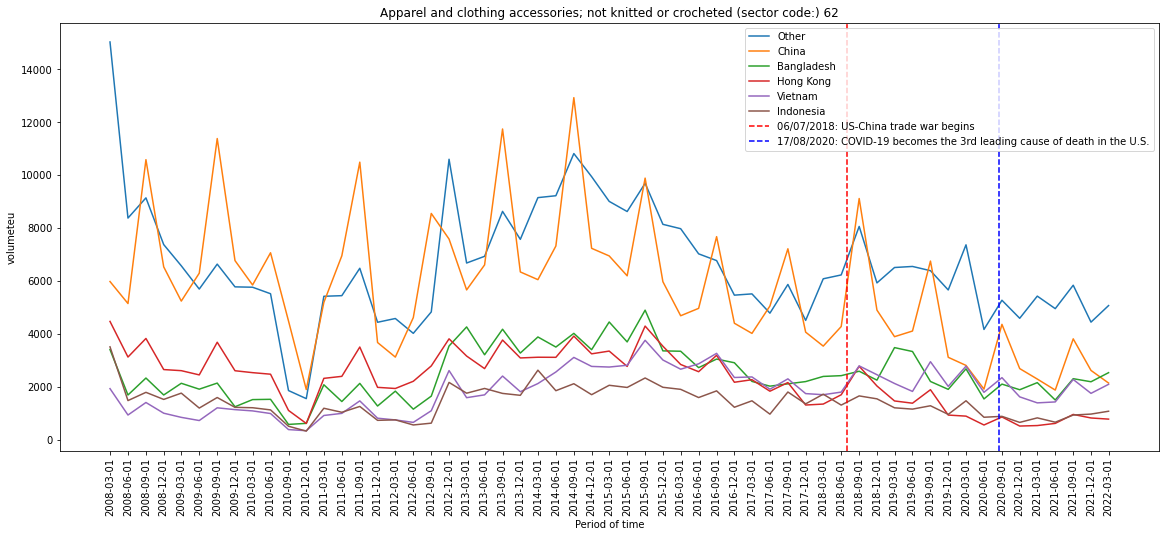

In [51]:
# 62 - Apparel and clothing accessories; not knitted or crocheted
sector_name = 'Apparel and clothing accessories; not knitted or crocheted'
start_sector_code = '62'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

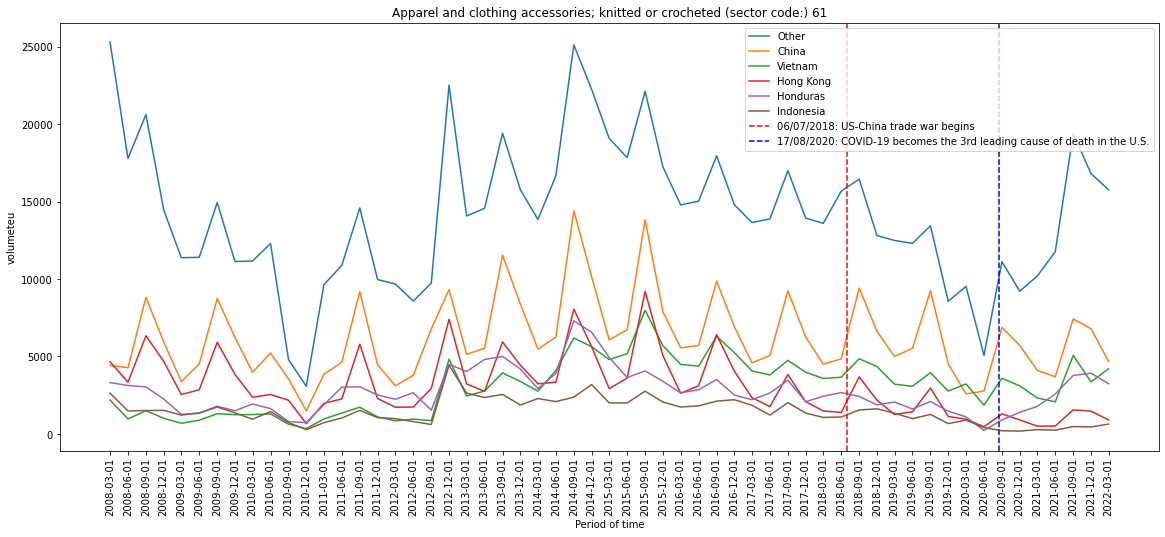

In [52]:
# 61 - Apparel and clothing accessories; knitted or crocheted
sector_name = 'Apparel and clothing accessories; knitted or crocheted'
start_sector_code = '61'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')', 
         period=["2008-03-01", "2022-03-01"])

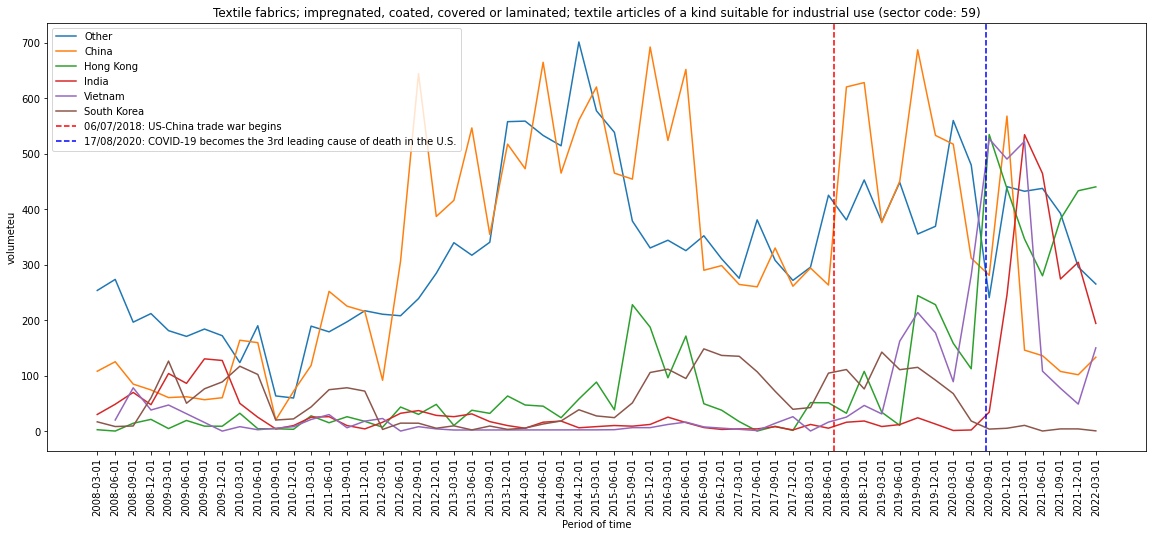

In [53]:
# 59 - Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use
sector_name = 'Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use'
start_sector_code = '59'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])


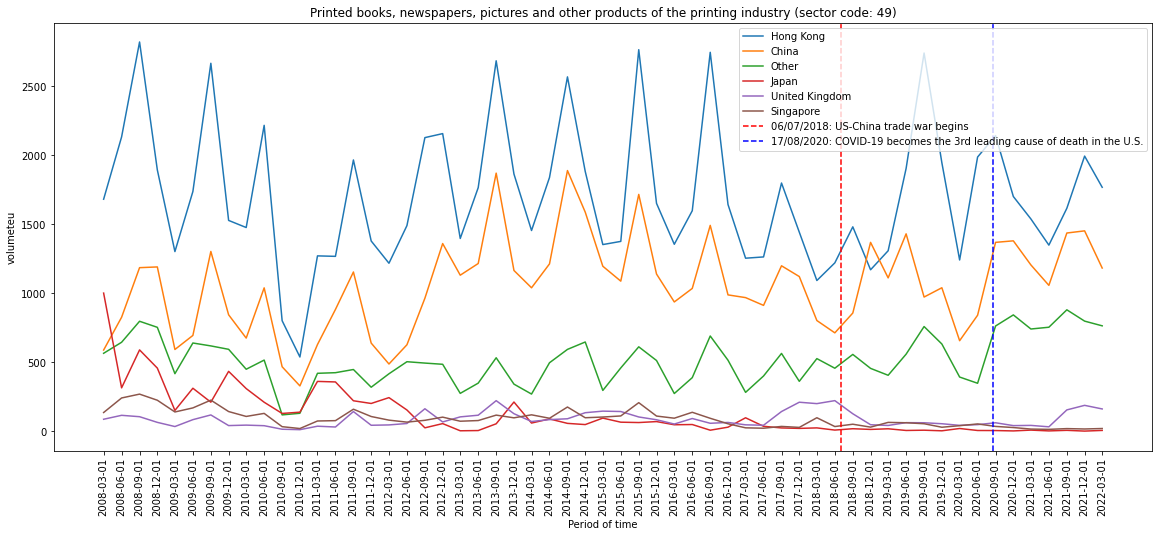

In [54]:
# 49 - Printed books, newspapers, pictures and other products of the printing industry; manuscripts, typescripts and plans
sector_name = 'Printed books, newspapers, pictures and other products of the printing industry'
start_sector_code = '49'
sector_list = get_sector_list(start_sector_code)
output='volumeteu'

country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

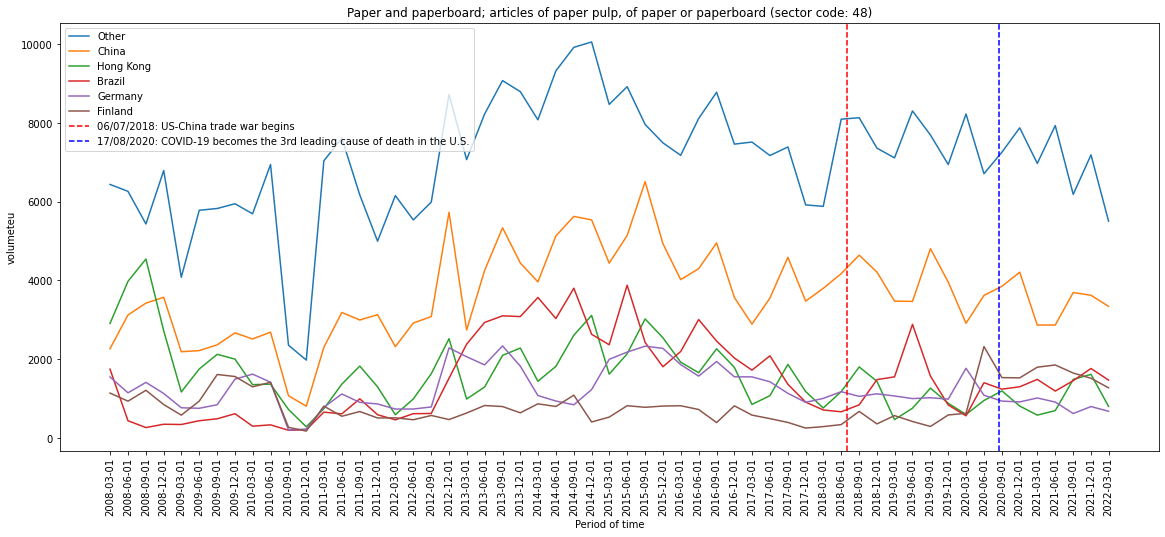

In [55]:
# 48 - Paper and paperboard; articles of paper pulp, of paper or paperboard
sector_name = 'Paper and paperboard; articles of paper pulp, of paper or paperboard'
start_sector_code = '48'
output='volumeteu'

sector_list = get_sector_list(start_sector_code)
country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])


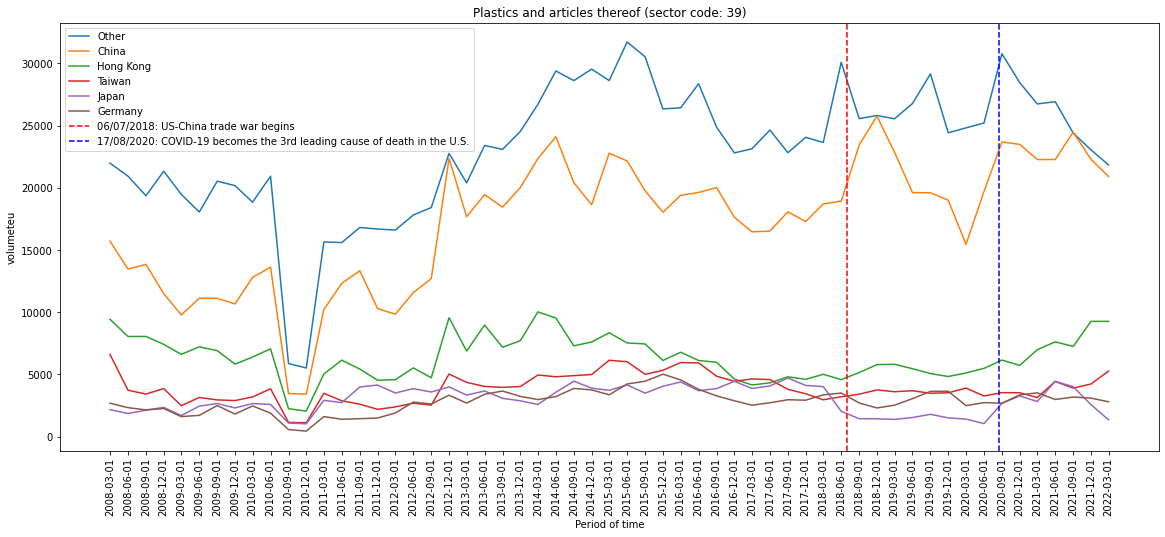

In [56]:
# 39 - Plastics and articles thereof
sector_name = 'Plastics and articles thereof'
start_sector_code = '39'
output='volumeteu'

sector_list = get_sector_list(start_sector_code)
country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

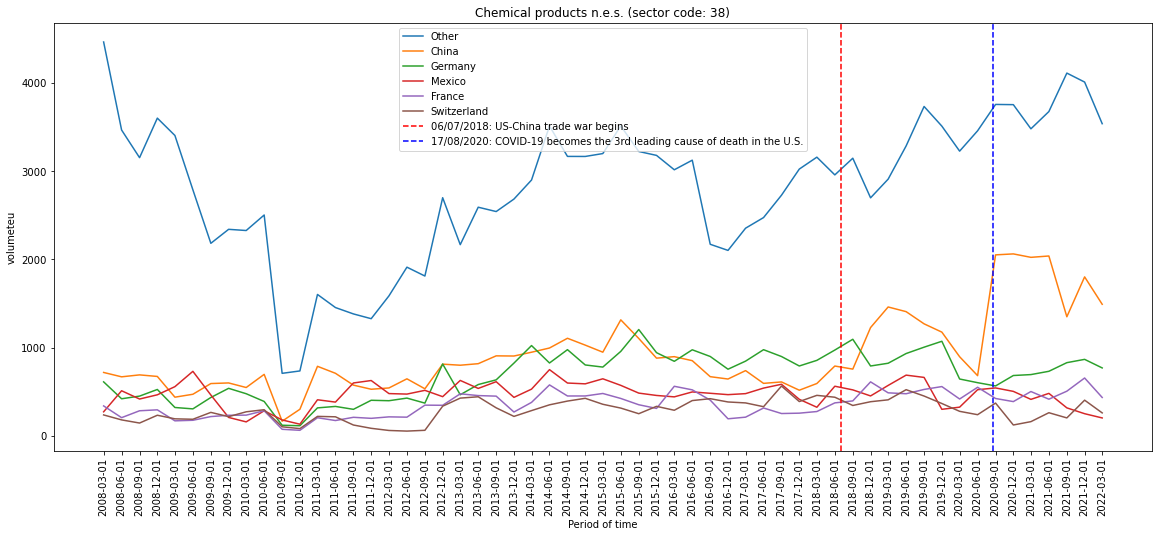

In [57]:
# 38 - Chemical products n.e.s.
sector_name = 'Chemical products n.e.s.'
start_sector_code = '38'
output='volumeteu'

sector_list = get_sector_list(start_sector_code)
country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')',
         period=["2008-03-01", "2022-03-01"])

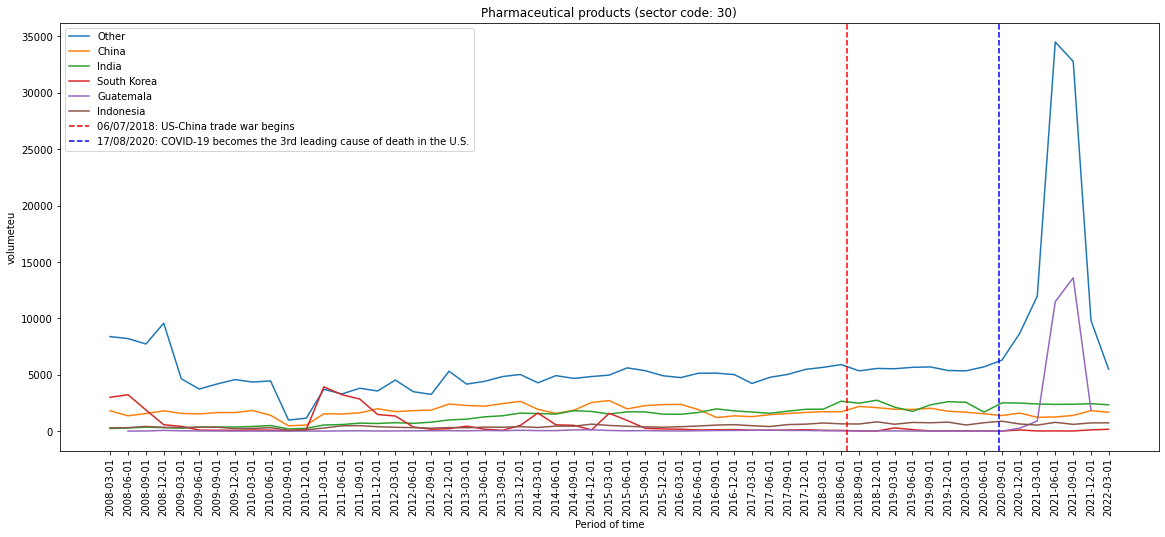

In [58]:
# 30 - Pharmaceutical products
sector_name = 'Pharmaceutical products'
start_sector_code = '30'
output='volumeteu'

sector_list = get_sector_list(start_sector_code)
country_list = get_max_countries(5, sector_list, output)

get_plot(sector_list, country_list, [], aggr_country_name,
         output='volumeteu', 
         title= sector_name + ' (sector code: '+start_sector_code+')', 
         period=["2008-03-01", "2022-03-01"])